# Baseline LSTM Model - All NIFTY Top 10 Stocks

This notebook trains LSTM models on all top 10 NIFTY stocks and computes average performance metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Stock List Configuration

In [2]:
# NIFTY Top 10 stocks
nifty_top_tickers = [
    "RELIANCE",
    "HDFCBANK",
    "TCS",
    "BHARTIARTL",
    "ICICIBANK",
    "SBIN",
    "INFY",
    "KOTAKBANK",
    "BAJFINANCE",
    "HINDUNILVR"
]

print(f"Total stocks to process: {len(nifty_top_tickers)}")
print(f"Stocks: {', '.join(nifty_top_tickers)}")

Total stocks to process: 10
Stocks: RELIANCE, HDFCBANK, TCS, BHARTIARTL, ICICIBANK, SBIN, INFY, KOTAKBANK, BAJFINANCE, HINDUNILVR


## Helper Functions

In [3]:
def create_sequences(X, y, sequence_length):
    """Create sequences for LSTM input"""
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)


class StockDataset(Dataset):
    """Custom Dataset for stock sequences"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    """LSTM model for binary stock price prediction"""
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.float().unsqueeze(1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())
    
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("✓ Helper functions defined")

✓ Helper functions defined


## Model Configuration

In [ ]:
# Hyperparameters (optimized based on your model.ipynb insights)
SEQUENCE_LENGTH = 10
HIDDEN_SIZE = 64     # Reduced to prevent overfitting
NUM_LAYERS = 2    # Simplified architecture
DROPOUT = 0.3  # Increased regularization
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15

print("Model Configuration:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  LSTM Layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Max Epochs: {NUM_EPOCHS}")
print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

Model Configuration:
  Sequence Length: 10
  Hidden Size: 64
  LSTM Layers: 2
  Dropout: 0.5
  Batch Size: 32
  Learning Rate: 0.001
  Max Epochs: 50
  Early Stopping Patience: 15


## Train Models for All Stocks

In [6]:
# Store results for all stocks
all_results = []

for stock_idx, stock_name in enumerate(nifty_top_tickers):
    print("\n" + "="*80)
    print(f"PROCESSING STOCK {stock_idx+1}/{len(nifty_top_tickers)}: {stock_name}")
    print("="*80)
    
    try:
        # 1. Load Data
        data_path = f'stock_data_daily_processed/{stock_name}_daily_data.csv'
        df = pd.read_csv(data_path, header=[0, 1], index_col=0, parse_dates=True)
        df.columns = [col[0] for col in df.columns]
        df.index.name = 'Date'
        
        # 2. Preprocessing
        df_clean = df.dropna()
        feature_cols = [col for col in df_clean.columns if col != 'target']
        X = df_clean[feature_cols].values
        y = df_clean['target'].values.astype(int)
        
        print(f"Data shape: {df_clean.shape} | Features: {len(feature_cols)}")
        print(f"Target: 0={np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%), 1={np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
        
        # 3. Create Sequences
        X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH)
        
        # 4. Train-Test Split
        train_size = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:train_size], X_seq[train_size:]
        y_train, y_test = y_seq[:train_size], y_seq[train_size:]
        
        # 5. Scaling
        scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
        scaler.fit(X_train_reshaped)
        X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)
        
        # 6. Create DataLoaders
        train_dataset = StockDataset(X_train_scaled, y_train)
        test_dataset = StockDataset(X_test_scaled, y_test)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")
        
        # 7. Initialize Model
        INPUT_SIZE = X_train_scaled.shape[2]
        model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False)
        
        # 8. Training Loop with Early Stopping
        best_val_acc = 0.0
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        print(f"\n{'Epoch':<6} {'TrLoss':<8} {'TrAcc':<8} {'VLoss':<8} {'VAcc':<8} {'Status':<20}")
        print("-"*60)
        
        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
            scheduler.step(val_loss)
            
            status = ""
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'models/{stock_name}_best_model.pth')
                status = "✓ Saved"
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            # Print every 10 epochs or when model improves
            if (epoch + 1) % 10 == 0 or status:
                print(f"{epoch+1:<6} {train_loss:<8.4f} {train_acc:<8.4f} {val_loss:<8.4f} {val_acc:<8.4f} {status:<20}")
            
            # Early stopping
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # 9. Final Evaluation
        model.load_state_dict(torch.load(f'models/{stock_name}_best_model.pth'))
        test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, test_loader, criterion, device)
        
        test_preds_int = test_preds.astype(int)
        test_labels_int = test_labels.astype(int)
        
        precision = precision_score(test_labels_int, test_preds_int, zero_division=0)
        recall = recall_score(test_labels_int, test_preds_int, zero_division=0)
        f1 = f1_score(test_labels_int, test_preds_int, zero_division=0)
        
        # Store results
        result = {
            'stock': stock_name,
            'accuracy': test_acc,
            'loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'best_epoch': epoch + 1 - epochs_no_improve
        }
        all_results.append(result)
        
        print(f"\n✓ {stock_name} Results:")
        print(f"  Accuracy: {test_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        
    except Exception as e:
        print(f"✗ Error processing {stock_name}: {str(e)}")
        all_results.append({
            'stock': stock_name,
            'accuracy': 0,
            'loss': 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'train_samples': 0,
            'test_samples': 0,
            'best_epoch': 0
        })

print("\n" + "="*80)
print("ALL STOCKS PROCESSED")
print("="*80)


PROCESSING STOCK 1/10: RELIANCE
Data shape: (1461, 41) | Features: 40
Target: 0=701 (48.0%), 1=760 (52.0%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
------------------------------------------------------------
1      0.6963   0.5026   0.6965   0.4777   ✓ Saved             
2      0.6933   0.5129   0.6984   0.5017   ✓ Saved             
6      0.6929   0.5155   0.7014   0.5086   ✓ Saved             
10     0.6877   0.5293   0.6995   0.4845                       
14     0.6858   0.5422   0.6956   0.5361   ✓ Saved             
20     0.6731   0.5793   0.7020   0.5326                       
Early stopping at epoch 29

✓ RELIANCE Results:
  Accuracy: 0.5361 | Precision: 0.5873 | Recall: 0.2534 | F1: 0.3541

PROCESSING STOCK 2/10: HDFCBANK
Data shape: (1461, 41) | Features: 40
Target: 0=711 (48.7%), 1=750 (51.3%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
------------

## Results Summary

In [7]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

print("="*80)
print("BASELINE MODEL RESULTS - ALL STOCKS")
print("="*80)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("AVERAGE METRICS ACROSS ALL STOCKS")
print("="*80)

avg_accuracy = results_df['accuracy'].mean()
avg_precision = results_df['precision'].mean()
avg_recall = results_df['recall'].mean()
avg_f1 = results_df['f1_score'].mean()

print(f"Average Accuracy:  {avg_accuracy:.4f} ({avg_accuracy*100:.2f}%)")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall:    {avg_recall:.4f}")
print(f"Average F1-Score:  {avg_f1:.4f}")

print(f"\nBest Performing Stock: {results_df.loc[results_df['accuracy'].idxmax(), 'stock']} ({results_df['accuracy'].max():.4f})")
print(f"Worst Performing Stock: {results_df.loc[results_df['accuracy'].idxmin(), 'stock']} ({results_df['accuracy'].min():.4f})")

print("="*80)

# Save results
results_df.to_csv('baseline_model_results.csv', index=False)
print("\n✓ Results saved to 'baseline_model_results.csv'")

BASELINE MODEL RESULTS - ALL STOCKS
     stock  accuracy     loss  precision   recall  f1_score  train_samples  test_samples  best_epoch
  RELIANCE  0.536082 0.695629   0.587302 0.253425  0.354067           1160           291          14
  HDFCBANK  0.539519 0.708985   0.572254 0.622642  0.596386           1160           291          21
       TCS  0.567010 0.690894   0.553922 0.763514  0.642045           1160           291           6
BHARTIARTL  0.529210 0.692667   0.514170 0.881944  0.649616           1160           291           1
 ICICIBANK  0.549828 0.691548   0.542169 0.888158  0.673317           1160           291           7
      SBIN  0.549828 0.687749   0.549828 1.000000  0.709534           1160           291           1
      INFY  0.508591 0.808225   0.496212 0.929078  0.646914           1160           291          25
 KOTAKBANK  0.539519 0.692495   0.556701 0.372414  0.446281           1160           291           1
BAJFINANCE  0.549828 0.719629   0.525000 0.459854  0.49

## Visualize Results

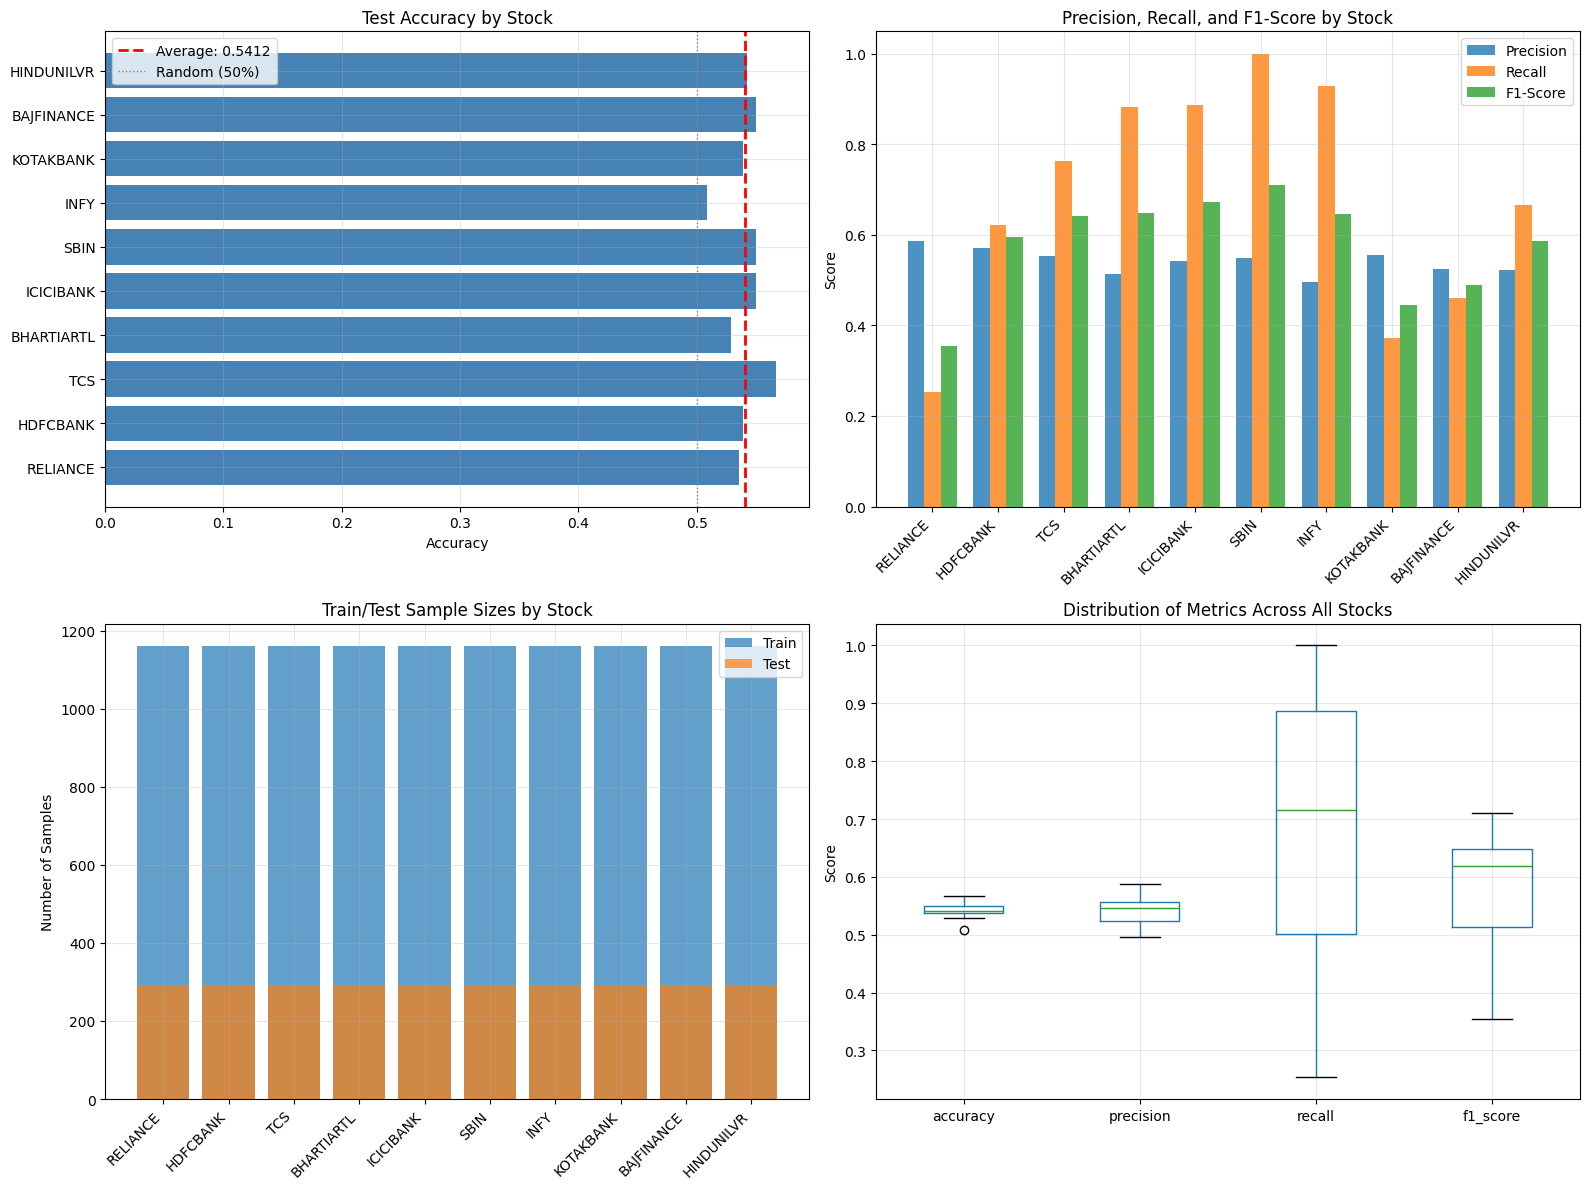

✓ Visualization saved to 'baseline_model_results.png'


In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
ax1.barh(results_df['stock'], results_df['accuracy'], color='steelblue')
ax1.axvline(x=avg_accuracy, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_accuracy:.4f}')
ax1.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, label='Random (50%)')
ax1.set_xlabel('Accuracy')
ax1.set_title('Test Accuracy by Stock')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Precision, Recall, F1
ax2 = axes[0, 1]
x = np.arange(len(results_df))
width = 0.25
ax2.bar(x - width, results_df['precision'], width, label='Precision', alpha=0.8)
ax2.bar(x, results_df['recall'], width, label='Recall', alpha=0.8)
ax2.bar(x + width, results_df['f1_score'], width, label='F1-Score', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['stock'], rotation=45, ha='right')
ax2.set_ylabel('Score')
ax2.set_title('Precision, Recall, and F1-Score by Stock')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Sample sizes
ax3 = axes[1, 0]
ax3.bar(results_df['stock'], results_df['train_samples'], label='Train', alpha=0.7)
ax3.bar(results_df['stock'], results_df['test_samples'], label='Test', alpha=0.7)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Train/Test Sample Sizes by Stock')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Metric distribution
ax4 = axes[1, 1]
metrics_data = results_df[['accuracy', 'precision', 'recall', 'f1_score']]
metrics_data.boxplot(ax=ax4)
ax4.set_ylabel('Score')
ax4.set_title('Distribution of Metrics Across All Stocks')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to 'baseline_model_results.png'")